In [19]:
import argparse
import sys
import os
from skimage import io

import torch
from torch import nn, optim
from torch.utils.data import DataLoader

from torchvision import datasets, transforms, utils
import matplotlib.patches as mpatches

from tqdm import tqdm

# from scheduler import CycleScheduler
from pt_utils import  Embeddings, Trainer, VQVAE, data_sampler, Vqvae2Adaptive
from torch.utils import data
from torch import distributed as dist

from umap import UMAP
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from collections import Counter
from skimage import transform, metrics
import skimage
import pandas as pd
import numpy as np
import glob

from torchsummary import summary

# from tqdm.notebook import trange, tqdm
from tqdm import trange, tqdm
import torchvision
from PIL import Image

import numpy as np
from sklearn.decomposition import PCA
from scipy.ndimage.filters import gaussian_filter
import scipy as sp
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

C:\Users\Администратор\AppData\Local\Temp\ipykernel_212\844596187.py:39: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [2]:
seed = 51
np.random.seed(seed)
torch.manual_seed(seed)

In [53]:
# dataset_path = '../datasets/bc_right_sub_left_minmax_4x_360'
# dataset_path = '../datasets/bc_left_sub_right_0.5_4x_360'
# dataset_path = '../datasets/bc_right_sub_left_0.5_4x_360'
# dataset_path = '../datasets/bc_left_sub_right_minmax_4x_360'
# dataset_path = '../datasets/bc_left_4x_360'
dataset_path = '../datasets/original/o_bc_left_9x_512_360'

resize_shape = (512, 512)

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Grayscale(),
        transforms.Normalize(0.5, 0.5),
    ]
)

dataset = datasets.ImageFolder(dataset_path, transform=transform)

In [75]:
# model_file = 'data/logs/emb_dim_1_n_embed_8192_bc_left_4x_360/vqvae_004_train_0.02043_test_0.02022.pt'
# model_file = 'data/logs/emb_dim_1_n_embed_8192_bc_left_sub_right_minmax_4x_360/vqvae_002_train_0.04045_test_0.03895.pt'
# model_file = 'data/logs/emb_dim_1_n_embed_8192_bc_right_sub_left_minmax_4x_360/vqvae_003_train_0.04287_test_0.04129.pt'
# model_file = '../data/logs/vq-vae-2/4x_emb_dim_32/weights/vqvae_011_train_0.00375_test_0.00375.pt'
# model_file = '../data/logs/vq-vae-2/4x/weights/vqvae_013_train_0.0038_test_0.0038.pt'
# model_file = 'data/logs/emb_dim_8_n_embed_8192_bc_left_9x_512_360/vqvae_002_train_0.02079_test_0.02053.pt'
# model_file = 'data/logs/emb_dim_1_n_embed_8192_bc_left_9x_512_360/vqvae_002_train_0.01976_test_0.01984.pt'
# model_file = 'data/logs/emb_dim_2_n_embed_8192_bc_left_9x_512_360/vqvae_002_train_0.01791_test_0.01756.pt'

device = "cuda"

# model =    VQVAE(in_channel=3,
model =    Vqvae2Adaptive(in_channel=1,
                 channel=4,
                 n_res_block=1,
                 n_res_channel=1,
                 embed_dim=1,
                 n_embed=8192,
                 decay=0.99).to(device)

# model =    Vqvae2Adaptive(in_channel=3,
#                  channel=128,
#                  n_res_block=6,
#                  n_res_channel=32,
#                  embed_dim=1,
#                  n_embed=8192,
#                  decay=0.99).to(device)

# model.load_state_dict(torch.load(model_file, map_location=torch.device('cuda')))

In [90]:
transform = transforms.Compose(
    [   
        transforms.CenterCrop((256,256)),
        transforms.ToTensor(),
        transforms.Grayscale(),
        transforms.Normalize(0.5, 0.5),
    ]
)

image = Image.open(image_path)
image = transform(image)
image = image.unsqueeze(0).to(device)

print(image.shape)

torch.Size([1, 1, 256, 256])


In [91]:
dataset_path = dataset.__dict__['root']
classes_folders = os.listdir(dataset_path)
classes_folders_images = [os.listdir(dataset_path + '/' + folder) for folder in classes_folders]
classes_folders_images_num = [len(os.listdir(dataset_path + '/' + folder)) for folder in classes_folders]
img_transform = dataset.__dict__['transform']

i=0
j=0

image_path = dataset_path + '/' + classes_folders[i] + '/' + classes_folders_images[i][j]

image = Image.open(image_path)
image = transform(image)
image = image.unsqueeze(0).to(device)

# print(image.shape)

quant_t, quant_b, diff, _, indx_b = model.encode(image)

print(quant_t.shape)
# print(quant_t.cpu().detach().numpy().flatten().shape)
print(quant_b.shape)
# print(quant_b.cpu().detach().numpy().flatten().shape)

torch.Size([1, 1, 32, 32])
torch.Size([1, 1, 64, 64])


In [14]:
res=model.decode(quant_t, quant_b)

res.shape

torch.Size([1, 3, 512, 512])

In [8]:
# embs_t, embs_b = Embeddings.get_vqvae2_embs(model, dataset)

dim_l=-6
n_embedded_l=-2048

In [9]:

embs_t = Embeddings.get_vqvae2_embs_t_adaptive(model, dataset, n_embedded_l=n_embedded_l,dim_l=dim_l)

# np.save(f'data/embs/embs_t_9x_512_360_emb_dim_8{dim_l}_n_embed_8192{n_embedded_l}_left_model_left.npy', embs_t)
# np.save('data/embs/embs_b_9x_512_360_emb_dim_8-7_n_embed_8192_left_model_left.npy', embs_b)

print(embs_t.shape)

Number of folders 1/5


Folder Ultra_Co11: 100%|██████████████████████████████████████████████████████████| 3240/3240 [00:29<00:00, 109.60it/s]


Number of folders 2/5


Folder Ultra_Co15: 100%|██████████████████████████████████████████████████████████| 3240/3240 [00:29<00:00, 111.04it/s]


Number of folders 3/5


Folder Ultra_Co25: 100%|██████████████████████████████████████████████████████████| 3240/3240 [00:29<00:00, 109.87it/s]


Number of folders 4/5


Folder Ultra_Co6_2: 100%|█████████████████████████████████████████████████████████| 3240/3240 [00:28<00:00, 111.76it/s]


Number of folders 5/5


Folder Ultra_Co8: 100%|███████████████████████████████████████████████████████████| 3240/3240 [00:29<00:00, 108.39it/s]


(16200, 8192)


In [3]:
dim_l=''
n_embedded_l=''

embs_t=np.load(f'data/embs/embs_t_9x_512_360_emb_dim_1{dim_l}_n_embed_8192{n_embedded_l}_left_model_left.npy')
embs_b=np.load(f'data/embs/embs_b_9x_512_360_emb_dim_1{dim_l}_n_embed_8192{n_embedded_l}_left_model_left.npy')

In [37]:
U, S, Vh = np.linalg.svd(embs_t, full_matrices=True)
# U, S, Vh = sp.linalg.svd(embs_t, full_matrices=True)

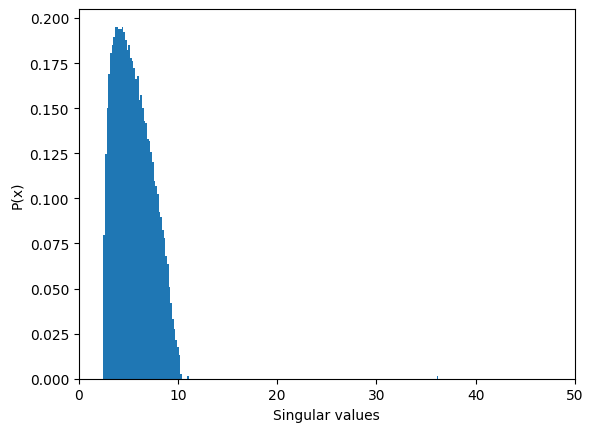

In [40]:
x = S

fig = plt.figure()
ax = fig.add_subplot(111)
n, bins, rectangles = ax.hist(x,200, density=True)
fig.canvas.draw()
plt.xlim(0,50)
plt.xlabel('Singular values')
plt.ylabel('P(x)')
plt.show()

In [4]:
seed = 51
np.random.seed(seed)
torch.manual_seed(seed)

umap_2d = UMAP(random_state=seed,n_components=2)

embs_b=np.array(embs_b)
embs_t=np.array(embs_t)

umaped_vct_2d_t = umap_2d.fit_transform(embs_t)
umaped_vct_2d_b = umap_2d.fit_transform(embs_b)

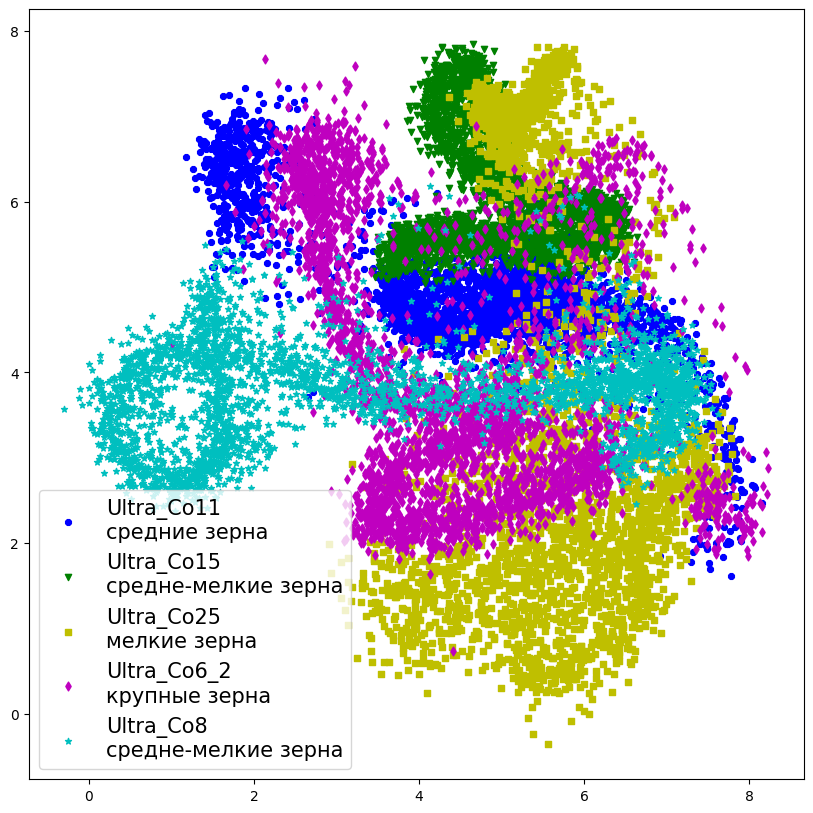

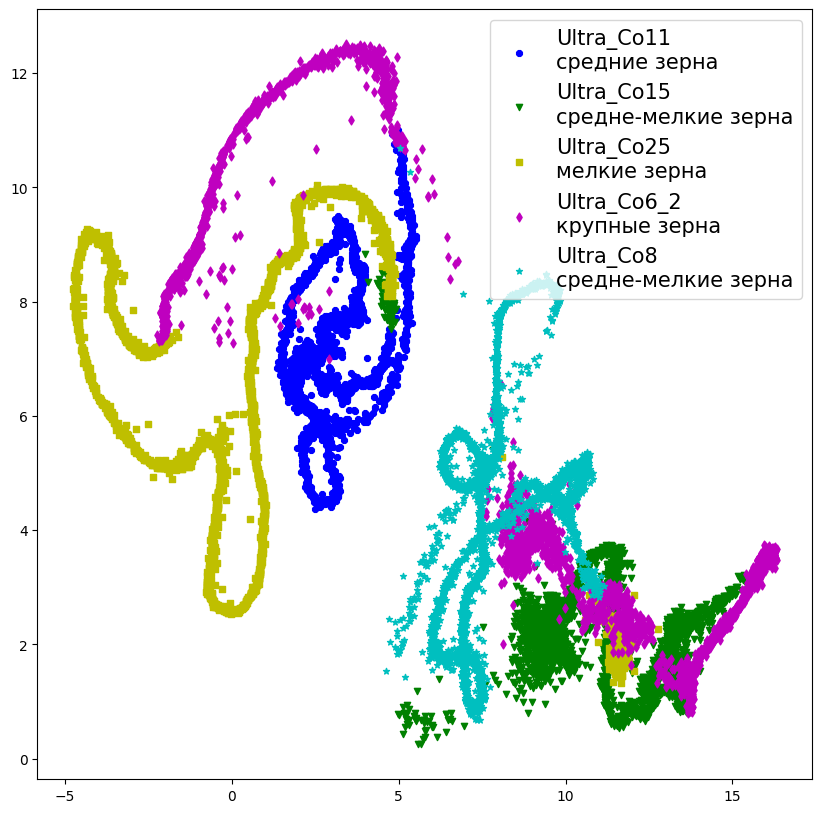

In [9]:
seed=51


types_dict = {'Ultra_Co11': 'средние зерна',
              'Ultra_Co25': 'мелкие зерна',
              'Ultra_Co8': 'средне-мелкие зерна',
              'Ultra_Co6_2': 'крупные зерна',
              'Ultra_Co15': 'средне-мелкие зерна'}

classes = dataset.__dict__['classes']

legend = [cls + '\n' + types_dict[cls] for cls in classes]

# name_1 = f'embs_space_seed={seed}_t_512_4x_360_minmax_emb_dim_1_n_embed_8192_right_sub_left_unique_model'
# name_1 = f'embs_space_seed={seed}_t_512_4x_360_emb_dim_1_n_embed_8192_right_sub_left_0.5_trunc_model_left' 
name_1 = f'embs_space_seed={seed}_t_512_4x_360_emb_dim_1_n_embed_8192_right_sub_left_0.5_trunc_model_left' 

# name_2 = f'embs_space_seed={seed}_b_512_4x_360_minmax_emb_dim_1_n_embed_8192_right_sub_left_unique_model'
# name_2 = f'embs_space_seed={seed}_b_512_4x_360_emb_dim_1_n_embed_8192_right_sub_left_0.5_trunc_model_left'
name_2 = f'embs_space_seed={seed}_b_512_4x_360_emb_dim_1_n_embed_8192_right_sub_left_0.5_trunc_model_left'


r_shape = (len(classes), -1, 2)

# save=True
save=False

Embeddings.plot_2d_scatter_embs(embs_scatter=umaped_vct_2d_t, legend=legend, r_shape=r_shape, save=save, name=name_1, N=10, M=10)
Embeddings.plot_2d_scatter_embs(embs_scatter=umaped_vct_2d_b, legend=legend, r_shape=r_shape, save=save, name=name_2, N=10, M=10)

In [ ]:
embs_t=np.load('data/embs/embs_t_512_4x_360_emb_dim_1_n_embed_8192_right_sub_left_0.5_trunc_model_left.npy')
embs_b=np.load('data/embs/embs_b_512_4x_360_emb_dim_1_n_embed_8192_right_sub_left_0.5_trunc_model_left.npy')

In [ ]:
embs_b.shape

In [12]:
embs_t.shape

(16200, 8192)

In [15]:
seed = 51
np.random.seed(seed)
torch.manual_seed(seed)

_,embs=train_test_split(embs_t,test_size=0.505679)

In [16]:
embs.shape

(8192, 8192)

In [17]:
eigenvalues_o, eigenvectors_o=np.linalg.eig(embs)

In [20]:
eigenvalues_tmp=[]
eigenvectors_tmp=[]

for i,value in tqdm(enumerate(eigenvalues_o)):
    if  value.real>-50  and value.imag <2 and value.real >-2.5 and value.real<4 and value.imag>-3:
        eigenvalues_tmp.append(value)
        eigenvectors_tmp.append(eigenvectors_o[i])

eigenvalues=np.array(eigenvalues_tmp)
eigenvectors=np.array(eigenvectors_tmp)

8192it [00:00, 136911.02it/s]


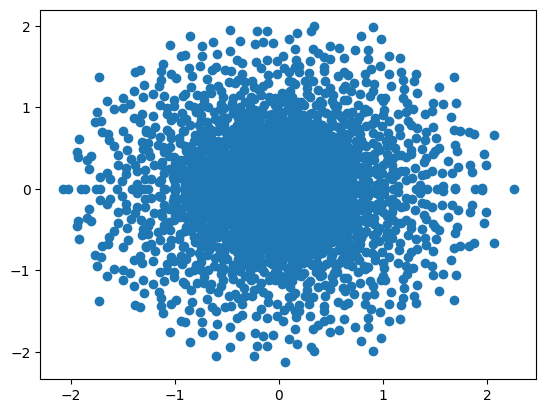

In [21]:
plt.scatter(eigenvalues.real, eigenvalues.imag)
plt.show()

In [22]:
eigenvalues_with_index=np.concatenate([eigenvalues.reshape((-1,1)), np.arange(len(eigenvalues)).reshape((-1,1))],axis=1)

C:\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


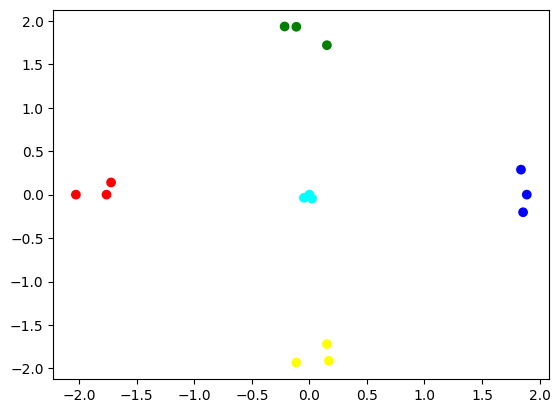

In [23]:
# points=[ [0,0], [0,-2.7], [0,2.7], [2.7,0], [-2.7,0] ]
points=[ [-2, 0], [2,0], [0,2], [0,-2], [0,0] ]
points_dict= {0:0,1:0,2:0, 3:0,4:0,5:0,6:0,7:0, 8:0}
eps=0.3
umap_2d = UMAP(random_state=seed,n_components=2)

n_points=3

np.random.shuffle(eigenvalues_with_index, )

edge_values=[]

for i, point in enumerate(points):
    for value in eigenvalues_with_index:
        dists=[]
        if abs(value[0].real-point[0])<eps and abs(value[0].imag-point[1])<eps and points_dict[i]<n_points:
            edge_values.append(value)
            points_dict[i]+=1

edge_values=np.array(edge_values)

vectors=eigenvectors[edge_values[:,1].real.astype(np.int32)]
vectors_2d_imag = umap_2d.fit_transform(vectors.imag)

colors=[]
c=['red', 'blue', 'green', 'yellow', 'cyan', 'peru', 'teal', 'greenyellow', 'purple', 'deeppink']

for i,point in enumerate(points):
    colors.extend([c[i]]*n_points)

plt.scatter(edge_values[:,0].real,edge_values[:,0].imag, c=colors)

C:\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
C:\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


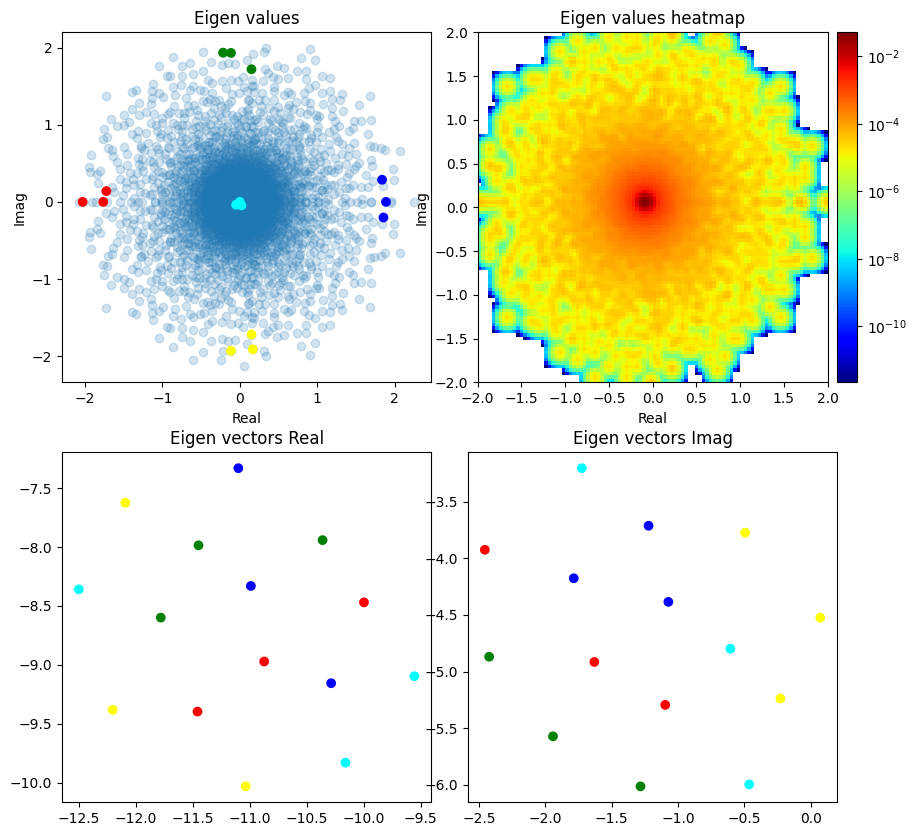

In [24]:
x_value=eigenvalues.real
y_value=eigenvalues.imag

heatmap, xedges, yedges = np.histogram2d(x_value, y_value, bins=100)
heatmap=heatmap.T
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

heatmap = gaussian_filter(heatmap, sigma=1)

heatmap/=np.sum(heatmap)

np.random.seed(51)
umap_2d = UMAP(random_state=seed,n_components=2)

vectors=eigenvectors[edge_values[:,1].real.astype(np.int32)]
vectors_2d_real = umap_2d.fit_transform(vectors.real)
vectors_2d_imag = umap_2d.fit_transform(vectors.imag)

extent=[-2, 2, -2 ,2]
fig,axes=plt.subplots(2,2, figsize=(10,10))
axes[0,0].scatter(x_value,y_value,alpha=0.2)
axes[0,0].scatter(edge_values[:,0].real,edge_values[:,0].imag, c=colors)
axes[0,0].set_title('Eigen values')
axes[0,0].set_xlabel('Real')
axes[0,0].set_ylabel('Imag')

fig.subplots_adjust(wspace=0.1)
# heatmap_ax=axes[0,1].imshow(heatmap, extent=extent, origin='lower', cmap=plt.cm.jet)
heatmap_ax=axes[0,1].imshow(heatmap, extent=extent, origin='lower', cmap=plt.cm.jet, interpolation='nearest', norm=mpl.colors.LogNorm())
axes[0,1].set_title('Eigen values heatmap')
axes[0,1].set_xlabel('Real')
axes[0,1].set_ylabel('Imag')

cax = fig.add_axes([0.9, 0.53, 0.02, 0.35])
cb=plt.colorbar(heatmap_ax,ax=axes[0,1], orientation='vertical',cax=cax)

axes[1,0].scatter(vectors_2d_real[:, 0], vectors_2d_real[:, 1],c=colors)
axes[1,0].set_title('Eigen vectors Real')

axes[1,1].scatter(vectors_2d_imag[:, 0], vectors_2d_imag[:, 1],c=colors)
axes[1,1].set_title('Eigen vectors Imag')


# plt.savefig('eig_5.png')
plt.show()

In [ ]:
# https://stackoverflow.com/questions/2369492/generate-a-heatmap-using-a-scatter-data-set

x=eigenvalues.real
y=eigenvalues.imag

heatmap, xedges, yedges = np.histogram2d(x, y, bins=100)
heatmap=heatmap.T
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

heatmap = gaussian_filter(heatmap, sigma=5)

plt.clf()
plt.imshow(heatmap, extent=extent, origin='lower', interpolation='sinc',cmap=plt.cm.jet,)
plt.show()

# Ошибки

In [ ]:
mse_losses = []
ssim_losses = []

visual_loader = DataLoader(
    dataset, batch_size=1, num_workers=2
)

for i, (img, label) in enumerate(visual_loader):
    model.zero_grad()
    img = img.to(device)

    out, latent_loss = model(img)
    predicted_image = np.transpose(out.cpu().detach().numpy()[0])
    original_image = np.transpose(img.cpu().detach().numpy()[0])

    mse_losses.append(metrics.mean_squared_error(original_image, predicted_image))
    ssim_losses.append(metrics.structural_similarity(original_image, predicted_image, multichannel=True))

mse_losses = np.array(mse_losses)
ssim_losses = np.array(ssim_losses)

In [ ]:
df_mse = pd.DataFrame()
df_ssim = pd.DataFrame()


In [ ]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))

names = ['Ultra_Co8\nсредние зерна', 'Ultra_Co11\nмелкие зерна', 'Ultra_Co6_2\nмелкие зерна',
         'Ultra_Co15\nкрупные зерна', 'Ultra_Co25\nсредне-мелкие зерна']

colors = ['b', 'g', 'y', 'm', 'c']
markers = ['8', 'v', 's', 'd', '*', ]

f_vects = []

cnt = Counter(np.array(dataset.samples)[:, 1])

for i in cnt.keys():
    emb_number = cnt[i]
    key = int(i)

    start = 0
    for val in range(int(i)):
        start += cnt[str(val)]

    end = start + emb_number

    mse_y = mse_losses[start:end]
    ssim_y = ssim_losses[start:end]

    df_mse[names[key]] = pd.Series(mse_y)
    df_ssim[names[key]] = pd.Series(ssim_y)

plt.rcParams['font.size'] = '20'

# plt.ylabel('MSE loss', fontsize=20)
name = 'vq-vae-2'
# plt.savefig(f'mse_ssim_losses_{name}_512.png')

# plt.show()

In [ ]:
plt.rcParams['font.size'] = '15'
name = 'vq-vae-2'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 12))
# plt.figure(figsize=(10,10))
df_ssim.boxplot(ax=ax2)
df_mse.boxplot(ax=ax1)

ax1.set_ylabel('MSE loss', fontsize=20)
ax2.set_ylabel('SSIM similarity', fontsize=20)

plt.savefig(f'mse_ssim_losses_{name}_512_boxplot.png')

plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))

names = ['Ultra_Co8\nсредние зерна', 'Ultra_Co11\nмелкие зерна', 'Ultra_Co6_2\nмелкие зерна',
         'Ultra_Co15\nкрупные зерна', 'Ultra_Co25\nсредне-мелкие зерна']

colors = ['b', 'g', 'y', 'm', 'c']
markers = ['8', 'v', 's', 'd', '*', ]

f_vects = []

cnt = Counter(np.array(dataset.samples)[:, 1])

for i in cnt.keys():
    emb_number = cnt[i]
    key = int(i)

    start = 0
    for val in range(int(i)):
        start += cnt[str(val)]

    end = start + emb_number

    x = np.arange(mse_losses.shape[0])[start:end]
    mse_y = mse_losses[start:end]
    ssim_y = ssim_losses[start:end]

    # ax1.plot(x, mse_y)
    ax1.scatter(x, mse_y)

    # ax2.plot(x, ssim_y)
    ax2.scatter(x, ssim_y)

plt.rcParams['font.size'] = '20'

ax1.legend(names, fontsize=15)
ax1.set_title('MSE image losses', fontsize=20)
ax1.set_xlabel('image number', fontsize=20)
ax1.set_ylabel('MSE loss', fontsize=20)

ax2.legend(names, fontsize=15)
ax2.set_title('Structural image similarity', fontsize=20)
ax2.set_xlabel('image number', fontsize=20)
ax2.set_ylabel('SSIM similarity', fontsize=20)

name = 'vq-vae-2'
plt.savefig(f'mse_ssim_losses_{name}_512.png')

plt.show()

In [ ]:
def get_emb_distr(f_vects, projection_axis, step, eps):
    """
    :param step:
    :param f_vects: ndarray shape (classes_num,N,2)
    :param projection_axis:
    :param eps:
    :return:
    """

    axis_start = f_vects[0, :, projection_axis].min()
    axis_end = f_vects[0, :, projection_axis].max()

    for vects in f_vects:
        min_val = vects[:, projection_axis].min()
        max_val = vects[:, projection_axis].max()

        if min_val < axis_start:
            axis_start = min_val

        if max_val > axis_end:
            axis_end = max_val

    axis_step = step * (axis_end - axis_start)
    axis_eps = eps * (axis_end - axis_start)
    axis_vals = np.arange(axis_start, axis_end, axis_step)

    points_distr = []

    for i, vects in enumerate(f_vects):
        points_distr.append([])
        for axis_val in axis_vals:
            counter = 0
            for point in vects[:, projection_axis]:
                if abs(point - axis_val) <= axis_eps:
                    counter += 1
            points_distr[i].append(counter)

    for i, distr in enumerate(points_distr):
        points_distr[i] = np.array(points_distr[i]) / sum(distr)

    return axis_vals, np.array(points_distr), axis_step, axis_eps

In [ ]:
names = ['Ultra_Co8\nсредние зерна', 'Ultra_Co11\nмелкие зерна', 'Ultra_Co6_2\nмелкие зерна',
         'Ultra_Co15\nкрупные зерна', 'Ultra_Co25\nсредне-мелкие зерна']

colors = ['b', 'g', 'y', 'm', 'c']
markers = ['8', 'v', 's', 'd', '*', ]

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))

title = 'VQ-VAE-2 embs projections'

ax1.set_title(f'{title}', fontsize=20)
ax1.set_xlabel('y val', fontsize=20)
ax1.set_ylabel('norm(count)', fontsize=20)

ax2.set_title(f'{title}', fontsize=20)
ax2.set_xlabel('x val', fontsize=20)
ax2.set_ylabel('norm(count)', fontsize=20)

step = 0.05
size = 4
# eps=step/2
eps = 0.2
projection_axis = 1

f_vects = umaped_vct_2d_b.reshape((5, 360, 2))

x_axis_vals, x_points_distr, x_step, x_eps = get_emb_distr(f_vects, projection_axis=0, step=step, eps=eps)
y_axis_vals, y_points_distr, y_step, y_eps = get_emb_distr(f_vects, projection_axis=1, step=step, eps=eps)

for i in range(len(x_points_distr)):
    ax1.plot(y_axis_vals, y_points_distr[i], color=colors[i])
    ax2.plot(x_axis_vals, x_points_distr[i], color=colors[i])

for i in range(len(x_points_distr)):
    # y projection
    ax1.scatter(y_axis_vals, y_points_distr[i], edgecolor=colors[i], s=size, marker=markers[i])

    # x prjection
    ax2.scatter(x_axis_vals, x_points_distr[i], edgecolor=colors[i], s=size, marker=markers[i])

ax1.legend(names + [
    f'шаг={round(y_step, 2)}, доля от длины оси={int(step * 100)}%\neps={round(y_eps, 2)}, доля от длины оси={int(eps * 100)}%'],
           fontsize=15)
ax2.legend(names + [
    f'шаг={round(x_step, 2)}, доля от длины оси={int(step * 100)}%\neps={round(x_eps, 2)}, доля от длины оси={int(eps * 100)}%'],
           fontsize=15)

plt.savefig(f'embs_projection_vq_vae_2_step={step}_eps={eps}.png')
plt.show()